# How you can drive safely in 2020


### Use KNN/Decision Tree/Random Forest classification algorithms from sklearn to predict the accident severity

Due to the limit of computer capacity, I am focusing on the Montgomery County of the State of Pennsylvania. I will only select a few features I believe are more relavant to severity. Categorical data will be treated with Pandas get_dummy method. Rows with missing values will be dropped.

In [6]:
# Import numpy, pandas, matpltlib.pyplot, sklearn modules and seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
plt.style.use('ggplot')

# Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import SelectFromModel


# Import DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

In [24]:
# read the survey results, slice the states of interests, and display the first 5 rows
df = pd.read_csv('./US_Accidents_May19.csv')
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2243939 entries, 0 to 2243938
Data columns (total 49 columns):
ID                       object
Source                   object
TMC                      float64
Severity                 int64
Start_Time               datetime64[ns]
End_Time                 datetime64[ns]
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description              object
Number                   float64
Street                   object
Side                     object
City                     object
County                   object
State                    object
Zipcode                  object
Country                  object
Timezone                 object
Airport_Code             object
Weather_Timestamp        object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             float

In [25]:
# Convert Start_Time and End_Time to datetypes
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

# Extract year, month, day, hour, weekday and time_duration information
df['Year']=df['Start_Time'].dt.year
df['Month']=df['Start_Time'].dt.strftime('%b')
df['Day']=df['Start_Time'].dt.day
df['Hour']=df['Start_Time'].dt.hour
df['Weekday']=df['Start_Time'].dt.strftime('%a')

# Extract the amount of time in the unit of minutes for each accident, round to the nearest integer
td='Time_Duration(min)'
df[td]=round((df['End_Time']-df['Start_Time'])/np.timedelta64(1,'m'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2243939 entries, 0 to 2243938
Data columns (total 55 columns):
ID                       object
Source                   object
TMC                      float64
Severity                 int64
Start_Time               datetime64[ns]
End_Time                 datetime64[ns]
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description              object
Number                   float64
Street                   object
Side                     object
City                     object
County                   object
State                    object
Zipcode                  object
Country                  object
Timezone                 object
Airport_Code             object
Weather_Timestamp        object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             float

In [26]:
df[td][df[td]<=0]

69720      -0.0
69721      -0.0
69722      -0.0
69723      -1.0
69724      -1.0
309389    -30.0
309390    -30.0
746173    -30.0
746174    -31.0
1482940   -30.0
1483025   -30.0
1483026   -31.0
2038017   -31.0
Name: Time_Duration(min), dtype: float64

In [27]:
# Drop the rows with td<0

neg_outliers=df[td]<=0

# Set outliers to NAN
df[neg_outliers] = np.nan

# Fill NAN with median
df.dropna(subset=[td],axis=0,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2243926 entries, 0 to 2243938
Data columns (total 55 columns):
ID                       object
Source                   object
TMC                      float64
Severity                 float64
Start_Time               datetime64[ns]
End_Time                 datetime64[ns]
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description              object
Number                   float64
Street                   object
Side                     object
City                     object
County                   object
State                    object
Zipcode                  object
Country                  object
Timezone                 object
Airport_Code             object
Weather_Timestamp        object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             flo

In [28]:
df[td][df[td]<=0]

Series([], Name: Time_Duration(min), dtype: float64)

In [29]:
# Remove outliers for Time_Duration(min): n * standard_deviation (n=3), backfill with median

n=3

median = df[td].median()
std = df[td].std()
outliers = (df[td] - median).abs() > std*n

# Set outliers to NAN
df[outliers] = np.nan

# Fill NAN with median
df[td].fillna(median, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2243926 entries, 0 to 2243938
Data columns (total 55 columns):
ID                       object
Source                   object
TMC                      float64
Severity                 float64
Start_Time               datetime64[ns]
End_Time                 datetime64[ns]
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description              object
Number                   float64
Street                   object
Side                     object
City                     object
County                   object
State                    object
Zipcode                  object
Country                  object
Timezone                 object
Airport_Code             object
Weather_Timestamp        object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             flo

In [35]:
print('Max time to clear an accident: {} minutes or {} hours or {} days; Min to clear an accident td: {} minutes.'.format(df[td].max(),round(df[td].max()/60), round(df[td].max()/60/24), df[td].min()))

Max time to clear an accident: 12424.0 minutes or 207 hours or 9 days; Min to clear an accident td: 1.0 minutes.


In [36]:
# Export the data
# df.to_csv('./US_Accidents_May19_clean.csv',index=False)

In [27]:
feature_lst=['Source','TMC','Severity','Start_Lng','Start_Lat','Distance(mi)','Side','City','County','State','Timezone','Temperature(F)','Humidity(%)','Pressure(in)', 'Visibility(mi)', 'Wind_Direction','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Turning_Loop','Sunrise_Sunset','Hour','Weekday', 'Time_Duration(min)']

In [38]:
df_sel=df[feature_lst]
df_sel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2243926 entries, 0 to 2243938
Data columns (total 34 columns):
Source                object
TMC                   float64
Severity              float64
Start_Lng             float64
Start_Lat             float64
Distance(mi)          float64
Side                  object
City                  object
County                object
State                 object
Timezone              object
Temperature(F)        float64
Humidity(%)           float64
Pressure(in)          float64
Visibility(mi)        float64
Wind_Direction        object
Weather_Condition     object
Amenity               float64
Bump                  float64
Crossing              float64
Give_Way              float64
Junction              float64
No_Exit               float64
Railway               float64
Roundabout            float64
Station               float64
Stop                  float64
Traffic_Calming       float64
Traffic_Signal        float64
Turning_Loop          flo

In [39]:
# Export the data with selected features
# df_sel.to_csv('./US_Accidents_May19_clean_sel.csv',index=False)

## Drop rows with missing values

In [43]:
# Check missing values
df_sel.isnull().mean()

Source                0.000217
TMC                   0.230302
Severity              0.000217
Start_Lng             0.000217
Start_Lat             0.000217
Distance(mi)          0.000217
Side                  0.000217
City                  0.000248
County                0.000217
State                 0.000217
Timezone              0.001172
Temperature(F)        0.027943
Humidity(%)           0.028925
Pressure(in)          0.025724
Visibility(mi)        0.031997
Wind_Direction        0.021230
Weather_Condition     0.032285
Amenity               0.000217
Bump                  0.000217
Crossing              0.000217
Give_Way              0.000217
Junction              0.000217
No_Exit               0.000217
Railway               0.000217
Roundabout            0.000217
Station               0.000217
Stop                  0.000217
Traffic_Calming       0.000217
Traffic_Signal        0.000217
Turning_Loop          0.000217
Sunrise_Sunset        0.000252
Hour                  0.000217
Weekday 

In [44]:
df_sel.dropna(subset=df_sel.columns[df_sel.isnull().mean()!=0],axis=0,inplace=True)
df_sel.shape

C:\Users\rzhou11\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(1663631, 34)

In [45]:
# Export the data with selected features
# df_sel.to_csv('./US_Accidents_May19_clean_sel_dropna.csv',index=False)

In [47]:
df_PA=df_sel.loc[df_sel.State=='PA']
df_PA.drop('State',axis=1, inplace=True)
df_PA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63248 entries, 197866 to 1725073
Data columns (total 33 columns):
Source                63248 non-null object
TMC                   63248 non-null float64
Severity              63248 non-null float64
Start_Lng             63248 non-null float64
Start_Lat             63248 non-null float64
Distance(mi)          63248 non-null float64
Side                  63248 non-null object
City                  63248 non-null object
County                63248 non-null object
Timezone              63248 non-null object
Temperature(F)        63248 non-null float64
Humidity(%)           63248 non-null float64
Pressure(in)          63248 non-null float64
Visibility(mi)        63248 non-null float64
Wind_Direction        63248 non-null object
Weather_Condition     63248 non-null object
Amenity               63248 non-null float64
Bump                  63248 non-null float64
Crossing              63248 non-null float64
Give_Way              63248 non-null

In [48]:
# df_PA.to_csv('./US_Accidents_May19_clean_sel_dropna_PA.csv',index=False)

Select one county: Montgomery County

In [49]:
df_PA_Mont=df_PA.loc[df_PA.County=='Montgomery']
df_PA_Mont.drop('County',axis=1,inplace=True)
df_PA_Mont.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25206 entries, 228554 to 1724934
Data columns (total 32 columns):
Source                25206 non-null object
TMC                   25206 non-null float64
Severity              25206 non-null float64
Start_Lng             25206 non-null float64
Start_Lat             25206 non-null float64
Distance(mi)          25206 non-null float64
Side                  25206 non-null object
City                  25206 non-null object
Timezone              25206 non-null object
Temperature(F)        25206 non-null float64
Humidity(%)           25206 non-null float64
Pressure(in)          25206 non-null float64
Visibility(mi)        25206 non-null float64
Wind_Direction        25206 non-null object
Weather_Condition     25206 non-null object
Amenity               25206 non-null float64
Bump                  25206 non-null float64
Crossing              25206 non-null float64
Give_Way              25206 non-null float64
Junction              25206 non-nul

In [50]:
# df_PA_Mont.to_csv('./US_Accidents_May19_clean_sel_dropna_PA_Mont.csv', index=False)

In [51]:
df_PA_Mont.shape

(25206, 32)

In [53]:
df_PA_Mont_dummy = pd.get_dummies(df_PA_Mont,drop_first=True)
df_PA_Mont_dummy.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 25206 entries, 228554 to 1724934
Columns: 141 entries, TMC to Weekday_Wed
dtypes: float64(24), uint8(117)
memory usage: 7.6 MB


In [54]:
# df_PA_Mont_dummy.to_csv('./US_Accidents_May19_clean_sel_dropna_PA_Mont_dummy.csv', index=False)

In [55]:
target='Severity'
# Create arrays for the features and the response variable
df=df_PA_Mont_dummy

y = df[target]
X = df.drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)


# Create a k-NN classifier with 6 neighbors
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the classifier to the data
knn.fit(X_train,y_train)

# Predict the labels for the training data X
y_pred = knn.predict(X_test)

print(knn.score(X_test, y_test))



print(accuracy_score(y_test, y_pred))

0.9354668077228246
0.9354668077228246


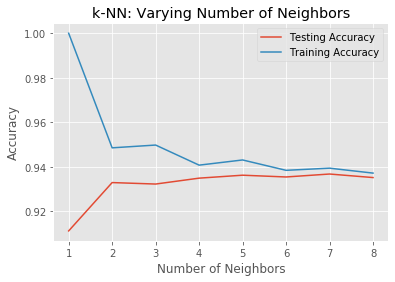

In [56]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()


In [57]:

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
      

[[   0    2    0    0]
 [   0 6977   38    0]
 [   0  447   97    0]
 [   0    1    0    0]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         2
         2.0       0.94      0.99      0.97      7015
         3.0       0.72      0.18      0.29       544
         4.0       0.00      0.00      0.00         1

    accuracy                           0.94      7562
   macro avg       0.41      0.29      0.31      7562
weighted avg       0.92      0.94      0.92      7562



C:\Users\rzhou11\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [58]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_neighbors': np.arange(1, 50)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(X_train, y_train)
print('knn_cv.best_params: {}.'.format(knn_cv.best_params_))
print('knn_cv.best_score_: {}.'.format(knn_cv.best_score_))


C:\Users\rzhou11\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


knn_cv.best_params: {'n_neighbors': 5}.
knn_cv.best_score_: 0.933121741101791.


## Decision Tree

In [40]:
# Decision Tree

df_PA_Mont_dummy=pd.read_csv('./US_Accidents_May19_clean_sel_dropna_PA_Mont_dummy.csv')

target='Severity'

# Create arrays for the features and the response variable
df=df_PA_Mont_dummy

y = df[target]
X = df.drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)


# Instantiate dt_entropy, set 'entropy' as the information criterion
dt_entropy = DecisionTreeClassifier(max_depth=8, criterion='entropy', random_state=1)


# Fit dt_entropy to the training set
dt_entropy.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred= dt_entropy.predict(X_test)

# Evaluate accuracy_entropy
accuracy_entropy = accuracy_score(y_test, y_pred)


# Print accuracy_entropy
print('Accuracy achieved by using entropy: {:.3f}.'.format(accuracy_entropy))



# Instantiate dt_gini, set 'gini' as the information criterion
dt_gini = DecisionTreeClassifier(max_depth=8, criterion='gini', random_state=1)


# Fit dt_entropy to the training set
dt_gini.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred= dt_gini.predict(X_test)

# Evaluate accuracy_entropy
accuracy_gini = accuracy_score(y_test, y_pred)




# Print accuracy_gini
print('Accuracy achieved by using the gini index: {:.3f}.'.format(accuracy_gini))

Accuracy achieved by using entropy: 0.967.
Accuracy achieved by using the gini index: 0.968.


Random Forest

In [35]:
# Random Forest

# Import data

df_PA_Mont_dummy=pd.read_csv('./US_Accidents_May19_clean_sel_dropna_PA_Mont_dummy.csv')

# Set the target feature
target='Severity'

# Create arrays for the features and the response variable
df=df_PA_Mont_dummy

y = df[target]
X = df.drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)


#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)


# Model Accuracy, how often is the classifier correct?
print("accuracy_score: {:.3f}.".format(accuracy_score(y_test, y_pred)))



accuracy_score: 0.973.


No handles with labels found to put in legend.


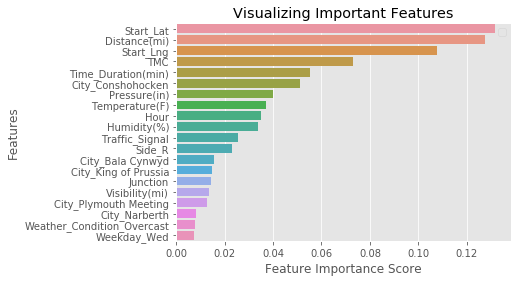

In [37]:
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)

# Creating a bar plot
sns.barplot(x=feature_imp[:20], y=feature_imp.index[:20])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [39]:
feature_imp.sort_values(ascending=False)[:20]

Start_Lat                     0.131561
Distance(mi)                  0.127453
Start_Lng                     0.107540
TMC                           0.072908
Time_Duration(min)            0.055205
City_Conshohocken             0.051265
Pressure(in)                  0.039808
Temperature(F)                0.037056
Hour                          0.035131
Humidity(%)                   0.033925
Traffic_Signal                0.025521
Side_R                        0.023022
City_Bala Cynwyd              0.015450
City_King of Prussia          0.014640
Junction                      0.014206
Visibility(mi)                0.013456
City_Plymouth Meeting         0.012803
City_Narberth                 0.008410
Weather_Condition_Overcast    0.007636
Weekday_Wed                   0.007445
dtype: float64

Select the top features

In [44]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.01
sfm = SelectFromModel(clf, threshold=0.01)

# Train the selector
sfm.fit(X_train, y_train)

# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])


Unnamed: 0
TMC
Start_Lng
Start_Lat
Distance(mi)
Temperature(F)
Humidity(%)
Pressure(in)
Give_Way
Traffic_Calming
Turning_Loop
Hour
Source_MapQuest-Bing
City_Ardmore
City_Colmar
City_King Of Prussia
City_Phoenixville


In [47]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)

# Apply The Full Featured Classifier To The Test Data
y_pred = clf.predict(X_test)

# View The Accuracy Of Our Full Feature (4 Features) Model
accuracy_score(y_test, y_pred)

0.9730265767552558

In [48]:
# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature (2 Features) Model
accuracy_score(y_test, y_important_pred)

0.9752082506941689